In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai

In [3]:
from pathlib import Path
import pickle
from PIL import Image

import matplotlib.pyplot as plt

from fastai.vision import ImageDataBunch
from fastai.vision import LabelLists
from fastai.vision import get_transforms

In [4]:
import torch; torch.__version__

'1.1.0'

In [5]:
cifar100_stats = (torch.tensor([0.5070751592371323, 0.48654887331495095, 0.4409178433670343]),
 torch.tensor([0.26733428587924035, 0.2564384629170881, 0.2761504713256853]))

In [6]:
path = Path('cifar100')
train_file = 'train'
test_file = 'test'

In [7]:
data = ImageDataBunch.from_folder(path,
                                  train=f'train_data',
                                  valid=f'valid_data',
                                  ds_tfms=get_transforms(),
                                  num_workers=10,
                                  bs=4096,
                                 ).normalize(cifar100_stats)


CPU times: user 5.65 s, sys: 1.47 s, total: 7.12 s
Wall time: 10.7 s


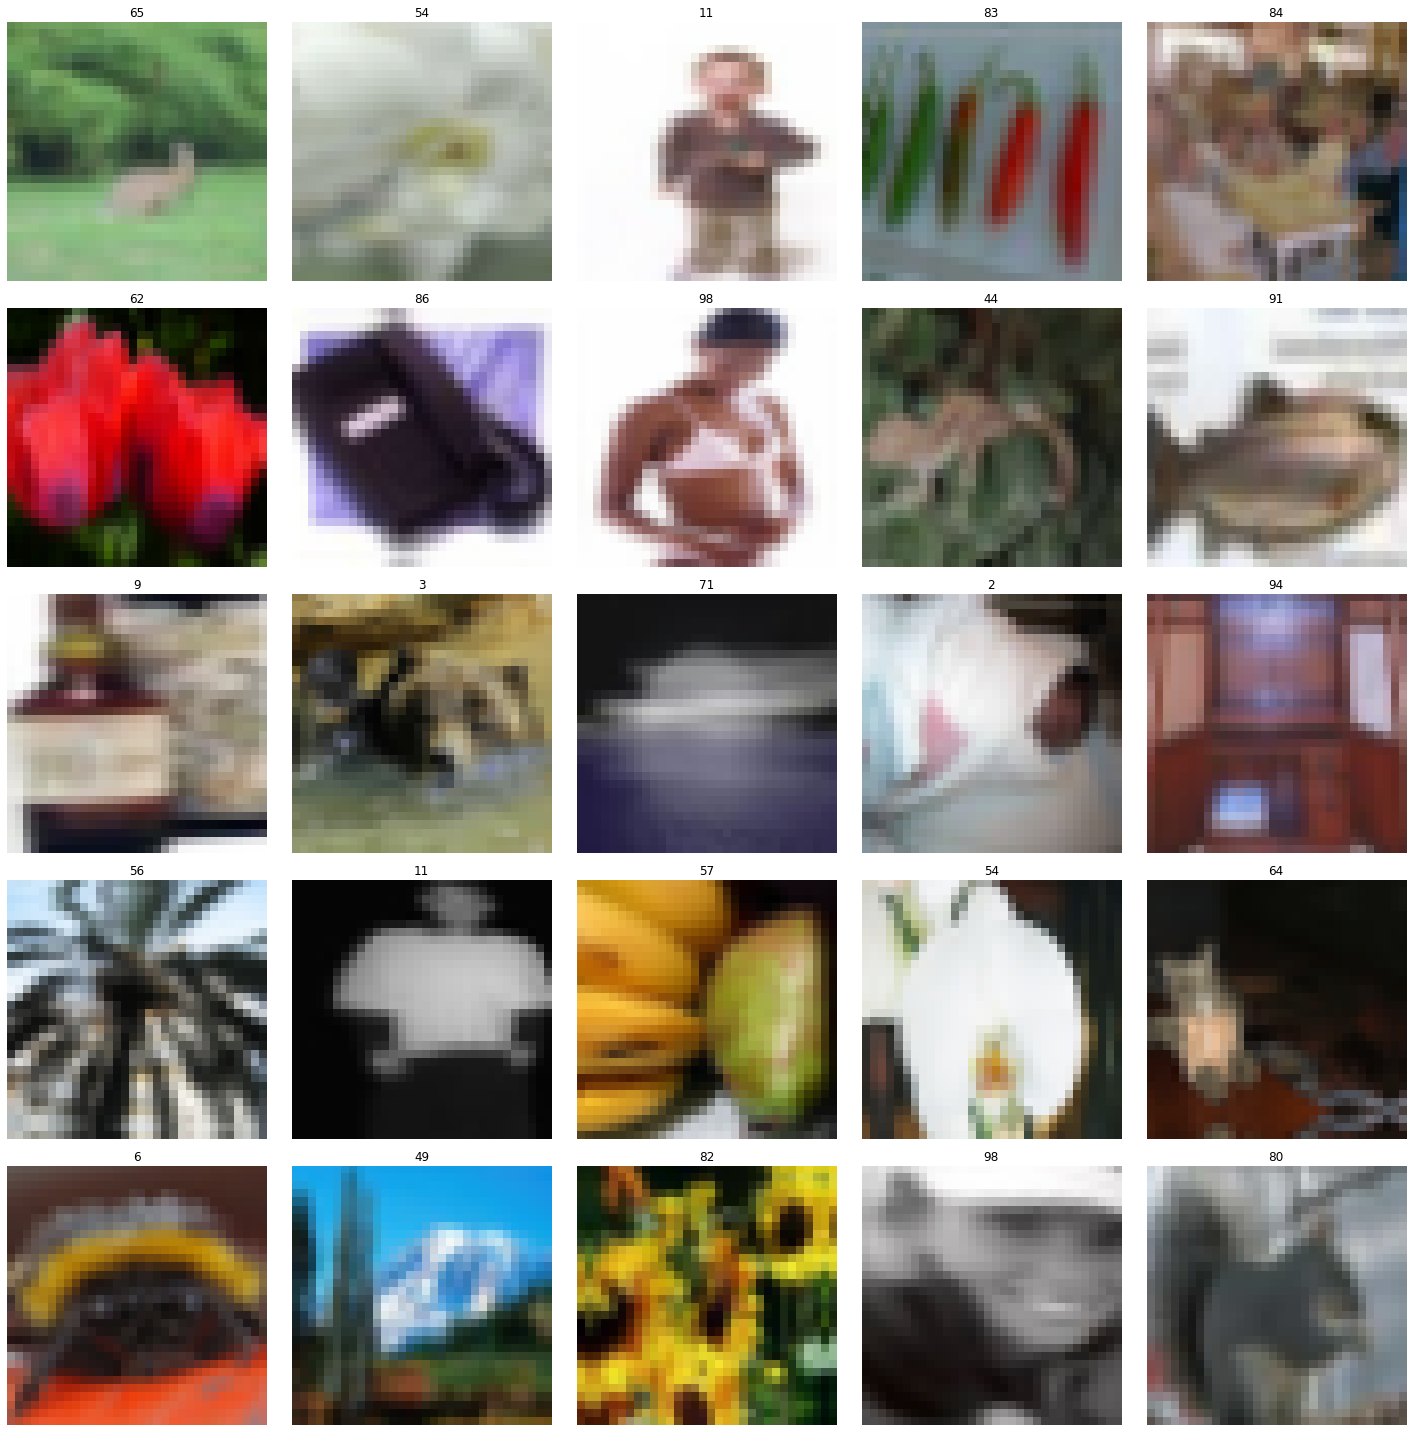

In [8]:
%%time
data.show_batch()

In [9]:
from torchvision import models
from fastai.vision import cnn_learner, accuracy

In [10]:
from torch import nn
from torchsummary import summary

avg_pool = nn.AvgPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=False)

In [11]:
learn = cnn_learner(data, models.resnet18, metrics=[accuracy], pretrained=False).mixup()

In [12]:
summary(learn.model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [13]:
learn.model._modules['0']._modules['3'] = avg_pool

In [14]:
learn.load('resnet_18_focal_loss2');

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


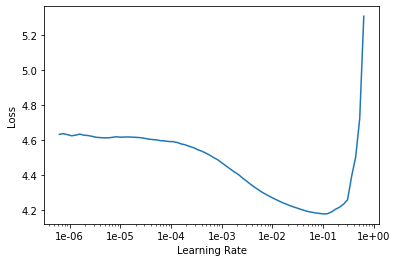

In [14]:
learn.recorder.plot()

In [15]:
from fastai.callbacks import SaveModelCallback
from torch import nn
import torch.nn.functional as F

In [16]:
# learn.fit_one_cycle(200, 6e-3, callbacks=SaveModelCallback(learn, name='resnet18_96'), start_epoch=180, wd=0.1)

####  Focal Loss

In [17]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, input, target, reduction):
        """
        input: [N, C], float32
        target: [N, ], int64
        """
        logpt = F.log_softmax(input, dim=1)
        pt = torch.exp(logpt)
        logpt = (1-pt) ** self.gamma * logpt
        loss = F.nll_loss(logpt, target, self.weight, reduction)
        return loss

In [18]:
# set focal loss
focal_loss = FocalLoss()
learn.loss_func = focal_loss

In [19]:
torch.cuda.is_available()

True

In [20]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learn.fit_one_cycle(500, 1e-3, callbacks=SaveModelCallback(learn, name='focal_loss_sz64_avgpool'), wd=0.15)

epoch,train_loss,valid_loss,accuracy,time
0,4.432249,3.505705,0.174500,00:19
1,4.323882,3.309733,0.231800,00:12
2,4.205905,3.258473,0.244100,00:12
3,4.092694,3.155821,0.261500,00:12
4,3.985735,3.043135,0.274100,00:12
5,3.887538,2.931414,0.288300,00:13
6,3.795547,2.832785,0.301100,00:12
7,3.713981,2.752259,0.312800,00:12
8,3.636658,2.683138,0.320900,00:12
9,3.566529,2.621807,0.333200,00:12


Better model found at epoch 0 with valid_loss value: 3.5057053565979004.
Better model found at epoch 1 with valid_loss value: 3.3097329139709473.
Better model found at epoch 2 with valid_loss value: 3.2584733963012695.
Better model found at epoch 3 with valid_loss value: 3.1558213233947754.
Better model found at epoch 4 with valid_loss value: 3.043135404586792.
Better model found at epoch 5 with valid_loss value: 2.9314136505126953.
Better model found at epoch 6 with valid_loss value: 2.832784652709961.
Better model found at epoch 7 with valid_loss value: 2.7522590160369873.
Better model found at epoch 8 with valid_loss value: 2.683137893676758.
Better model found at epoch 9 with valid_loss value: 2.621807098388672.
Better model found at epoch 10 with valid_loss value: 2.5640008449554443.
Better model found at epoch 11 with valid_loss value: 2.5075149536132812.
Better model found at epoch 12 with valid_loss value: 2.4562292098999023.
Better model found at epoch 13 with valid_loss value

In [29]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learn.fit_one_cycle(200, 1e-3, callbacks=SaveModelCallback(learn, name='resnet_18_focal_loss2'), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.412135,1.092895,0.668300,00:17
1,1.403452,1.090433,0.669100,00:17
2,1.399692,1.090241,0.668100,00:17
3,1.401252,1.090482,0.668900,00:17
4,1.398963,1.089958,0.669100,00:17
5,1.397686,1.087383,0.671500,00:17
6,1.395546,1.088066,0.671600,00:17
7,1.391761,1.086572,0.670400,00:18
8,1.390751,1.088478,0.669700,00:17
9,1.390829,1.089506,0.670500,00:17


Better model found at epoch 0 with valid_loss value: 1.0928946733474731.
Better model found at epoch 1 with valid_loss value: 1.0904326438903809.
Better model found at epoch 2 with valid_loss value: 1.0902410745620728.
Better model found at epoch 4 with valid_loss value: 1.089957594871521.
Better model found at epoch 5 with valid_loss value: 1.0873830318450928.
Better model found at epoch 7 with valid_loss value: 1.086572289466858.


In [32]:
learn.load('resnet_18_focal_loss2');

In [33]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learn.fit_one_cycle(200, 1e-3, callbacks=SaveModelCallback(learn, name='resnet_18_focal_loss2'), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.517546,1.429511,0.669600,00:17
1,1.507275,1.413386,0.671500,00:17
2,1.495315,1.395798,0.671300,00:17
3,1.485747,1.379543,0.673000,00:18
4,1.474151,1.364876,0.672800,00:17
5,1.460931,1.354243,0.673100,00:17
6,1.449556,1.343997,0.672800,00:18
7,1.440124,1.336930,0.673000,00:18
8,1.432185,1.335551,0.674200,00:18
9,1.423800,1.333044,0.674300,00:17


Better model found at epoch 0 with valid_loss value: 1.4295111894607544.
Better model found at epoch 1 with valid_loss value: 1.4133862257003784.
Better model found at epoch 2 with valid_loss value: 1.3957982063293457.
Better model found at epoch 3 with valid_loss value: 1.3795428276062012.
Better model found at epoch 4 with valid_loss value: 1.3648756742477417.
Better model found at epoch 5 with valid_loss value: 1.3542433977127075.
Better model found at epoch 6 with valid_loss value: 1.3439967632293701.
Better model found at epoch 7 with valid_loss value: 1.3369300365447998.
Better model found at epoch 8 with valid_loss value: 1.3355505466461182.
Better model found at epoch 9 with valid_loss value: 1.3330435752868652.
Better model found at epoch 10 with valid_loss value: 1.3328150510787964.
Better model found at epoch 112 with valid_loss value: 1.3323487043380737.
Better model found at epoch 127 with valid_loss value: 1.3284796476364136.
Better model found at epoch 128 with valid_los

In [35]:
from fastai.callbacks import ReduceLROnPlateauCallback

In [41]:
cb = ReduceLROnPlateauCallback(learn, patience=5, factor=0.5)

In [43]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learn.fit_one_cycle(200, 1e-3, callbacks=SaveModelCallback(learn, name='resnet_18_focal_loss2'), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.712098,2.820930,0.402000,00:17
1,1.692564,2.119849,0.521300,00:17
2,1.675956,1.973245,0.549700,00:17
3,1.653836,1.911193,0.561600,00:17
4,1.629140,1.864846,0.570300,00:17
5,1.599716,1.826674,0.577200,00:17
6,1.572340,1.791006,0.584600,00:17
7,1.543894,1.754567,0.590800,00:17
8,1.517390,1.720562,0.598500,00:18
9,1.486276,1.685708,0.608100,00:17


Better model found at epoch 0 with valid_loss value: 2.820929527282715.
Better model found at epoch 1 with valid_loss value: 2.11984920501709.
Better model found at epoch 2 with valid_loss value: 1.9732446670532227.
Better model found at epoch 3 with valid_loss value: 1.911192774772644.
Better model found at epoch 4 with valid_loss value: 1.8648464679718018.
Better model found at epoch 5 with valid_loss value: 1.826673984527588.
Better model found at epoch 6 with valid_loss value: 1.7910062074661255.
Better model found at epoch 7 with valid_loss value: 1.75456702709198.
Better model found at epoch 8 with valid_loss value: 1.72056245803833.
Better model found at epoch 9 with valid_loss value: 1.6857081651687622.
Better model found at epoch 10 with valid_loss value: 1.651167631149292.
Better model found at epoch 11 with valid_loss value: 1.6211827993392944.
Better model found at epoch 12 with valid_loss value: 1.5911500453948975.
Better model found at epoch 13 with valid_loss value: 1.56

In [44]:
learn.save('focal2')

In [37]:
from fastai.vision import ClassificationInterpretation

In [38]:
interp = ClassificationInterpretation.from_learner(learn)

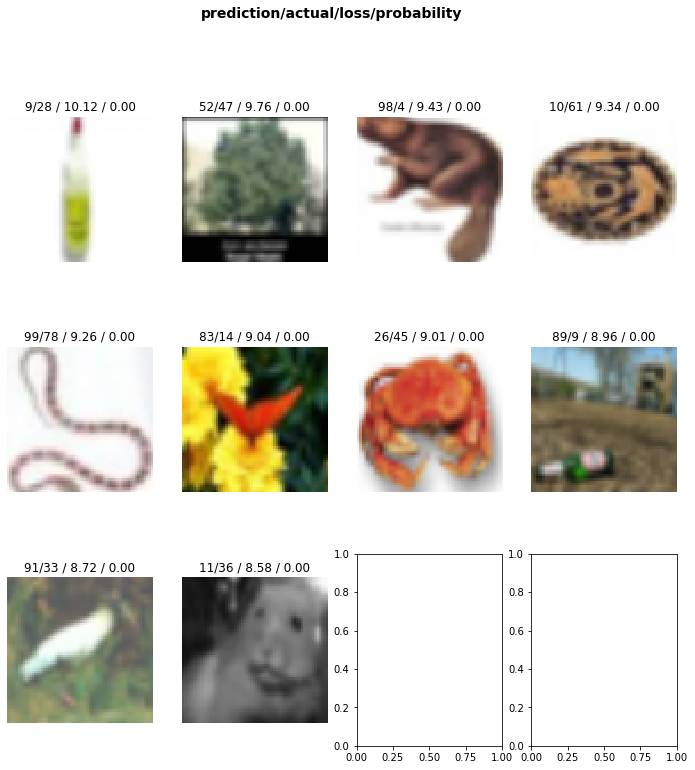

In [40]:
interp.plot_top_losses(10, heatmap=True)

In [34]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learn.fit_one_cycle(300, 1e-3, callbacks=SaveModelCallback(learn, name='resnet_18_focal_loss2'), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.123879,1.291751,0.700900,00:18
1,1.122706,1.292221,0.701000,00:18
2,1.119743,1.290440,0.702900,00:18
3,1.119226,1.291373,0.701100,00:18
4,1.117644,1.289775,0.702400,00:18
5,1.117841,1.290239,0.701100,00:17
6,1.118203,1.291514,0.701200,00:18
7,1.117852,1.291453,0.701400,00:18
8,1.116300,1.291889,0.700900,00:17
9,1.115941,1.295201,0.699300,00:18


Better model found at epoch 0 with valid_loss value: 1.2917510271072388.
Better model found at epoch 2 with valid_loss value: 1.2904402017593384.
Better model found at epoch 4 with valid_loss value: 1.2897754907608032.
Better model found at epoch 12 with valid_loss value: 1.2884386777877808.
Better model found at epoch 13 with valid_loss value: 1.2857179641723633.
Better model found at epoch 16 with valid_loss value: 1.2844939231872559.
Better model found at epoch 214 with valid_loss value: 1.2817459106445312.
Better model found at epoch 216 with valid_loss value: 1.2780323028564453.
Better model found at epoch 217 with valid_loss value: 1.2700130939483643.
Better model found at epoch 229 with valid_loss value: 1.2606112957000732.
Better model found at epoch 245 with valid_loss value: 1.2582151889801025.
Better model found at epoch 246 with valid_loss value: 1.2572892904281616.
Better model found at epoch 248 with valid_loss value: 1.2562683820724487.
Better model found at epoch 270 wi

In [80]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learn.fit_one_cycle(400, slice(5e-5, 5e-4), callbacks=SaveModelCallback(learn, name='resnet_18_focal_loss2'), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.493433,1.516639,0.571400,01:36
1,1.489532,1.513066,0.570600,01:33
2,1.486453,1.508569,0.570900,01:33
3,1.481628,1.506579,0.572400,01:33
4,1.487023,1.503677,0.573100,01:33
5,1.486696,1.504006,0.570900,01:33
6,1.480306,1.501443,0.573000,01:33
7,1.468448,1.502928,0.572600,01:33
8,1.466722,1.500718,0.572300,01:33
9,1.464505,1.498807,0.573100,01:34


Better model found at epoch 0 with valid_loss value: 1.5166391134262085.
Better model found at epoch 1 with valid_loss value: 1.513066053390503.
Better model found at epoch 2 with valid_loss value: 1.5085688829421997.
Better model found at epoch 3 with valid_loss value: 1.5065792798995972.
Better model found at epoch 4 with valid_loss value: 1.5036768913269043.
Better model found at epoch 6 with valid_loss value: 1.501442790031433.
Better model found at epoch 8 with valid_loss value: 1.5007184743881226.
Better model found at epoch 9 with valid_loss value: 1.4988065958023071.
Better model found at epoch 10 with valid_loss value: 1.4931983947753906.
Better model found at epoch 14 with valid_loss value: 1.492000937461853.
Better model found at epoch 15 with valid_loss value: 1.489385962486267.
Better model found at epoch 16 with valid_loss value: 1.4876692295074463.


In [49]:





learn.mixup()

Learner(data=ImageDataBunch;

Train: LabelList (50000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
0,0,0,0,0
Path: cifar100;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
0,0,0,0,0
Path: cifar100;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (co

In [50]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


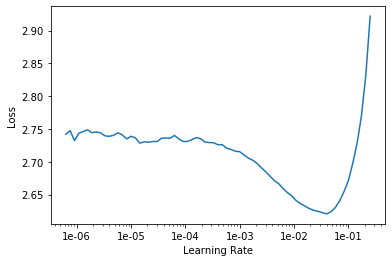

In [51]:
learn.recorder.plot()

In [52]:
learn.fit_one_cycle(20, 8e-3, callbacks=SaveModelCallback(learn, name='resnet18_mixup_best'))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.612432,1.951376,0.509300,0.490700,01:21
1,2.451968,1.908818,0.496900,0.503100,01:22
2,2.371654,1.894474,0.487900,0.512100,01:21
3,2.347642,1.953148,0.507500,0.492500,01:31
4,2.346386,2.041557,0.522100,0.477900,01:32
5,2.357399,2.032150,0.516900,0.483100,01:34
6,2.351927,1.975747,0.507700,0.492300,01:29
7,2.330228,2.028065,0.514800,0.485200,01:29
8,2.309005,1.983214,0.506500,0.493500,01:29
9,2.266371,1.995203,0.508300,0.491700,01:29


Better model found at epoch 0 with valid_loss value: 1.95137619972229.
Better model found at epoch 1 with valid_loss value: 1.9088181257247925.
Better model found at epoch 2 with valid_loss value: 1.8944743871688843.
Better model found at epoch 17 with valid_loss value: 1.8790210485458374.
Better model found at epoch 18 with valid_loss value: 1.8781919479370117.


In [53]:
learn.fit_one_cycle(60, 2e-4, callbacks=SaveModelCallback(learn, name='resnet18_mixup_best2'), wd=0.1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.899604,1.879239,0.471700,0.528300,01:23
1,1.886573,1.877223,0.470900,0.529100,01:24
2,1.887426,1.877854,0.471400,0.528600,01:23
3,1.898541,1.878977,0.471300,0.528700,01:21
4,1.893189,1.873574,0.470300,0.529700,01:25
5,1.885780,1.873764,0.472000,0.528000,01:22
6,1.881801,1.876105,0.470700,0.529300,01:21
7,1.886459,1.876190,0.470900,0.529100,01:21
8,1.889211,1.871285,0.469600,0.530400,01:21
9,1.886887,1.869621,0.469000,0.531000,01:21


Better model found at epoch 0 with valid_loss value: 1.8792387247085571.
Better model found at epoch 1 with valid_loss value: 1.877223014831543.
Better model found at epoch 4 with valid_loss value: 1.873573660850525.
Better model found at epoch 8 with valid_loss value: 1.871285319328308.
Better model found at epoch 9 with valid_loss value: 1.8696205615997314.
Better model found at epoch 11 with valid_loss value: 1.8672223091125488.
Better model found at epoch 18 with valid_loss value: 1.864001750946045.


In [55]:
# learn.loss_func??

In [56]:
learn.save('mixup60')

In [11]:
learn.load('mixup60')

Learner(data=ImageDataBunch;

Train: LabelList (50000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
0,0,0,0,0
Path: cifar100;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
0,0,0,0,0
Path: cifar100;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (co

In [ ]:
# learn.save('20')

In [26]:
# from torch import nn
# import torch
# import torch.nn.functional as F
# import numpy as np



# class FocalLoss(nn.Module):

#     def __init__(self, num_class, alpha=None, gamma=2, balance_index=-1, smooth=None, size_average=True):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.smooth = smooth
#         self.size_average = size_average

#     def forward(self, logit, target):
        
#         return loss

###  Progressive resizing at 64

In [40]:
data = ImageDataBunch.from_folder(path,
                                  train='train_data',
                                  valid='valid_data',
                                  ds_tfms=get_transforms(),
                                  num_workers=0,
                                  size=64,
                                  bs=1024
                                 ).normalize(cifar100_stats)

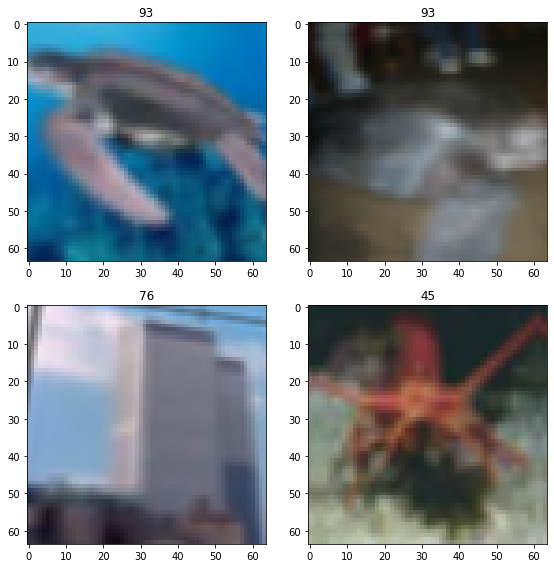

In [41]:
data.show_batch(rows=2, hide_axis=False)

In [42]:
learn = cnn_learner(data, models.resnet18, metrics=[error_rate, accuracy], pretrained=False).mixup()

In [43]:
learn.load('mixup60')

Learner(data=ImageDataBunch;

Train: LabelList (50000 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,0,0,0,0
Path: cifar100;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,0,0,0,0
Path: cifar100;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (co

In [13]:
# focal_loss = FocalLoss(alpha=0.25, gamma=2)

In [29]:
# learn.loss_func = old_loss

In [30]:
# ??learn.loss_func

In [17]:
# learn.loss_func = FocalLoss(num_class=100, alpha=0.25, gamma=2)

In [38]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


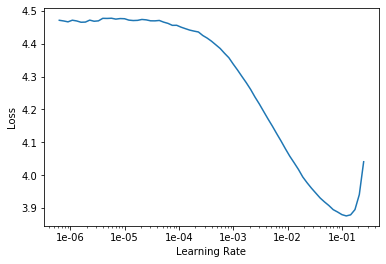

In [39]:
learn.recorder.plot()

In [ ]:
learn.load('mixup60')

In [44]:
learn.fit_one_cycle(200, 6e-3, callbacks=SaveModelCallback(learn, name='resnet18_64'), wd=0.1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.846863,3.049490,0.738200,0.261800,02:01
1,3.502106,2.709878,0.674800,0.325200,01:59
2,3.289765,2.527004,0.638700,0.361300,02:01
3,3.146404,2.373744,0.604500,0.395500,01:59
4,3.035338,2.266037,0.580600,0.419400,01:59
5,2.940037,2.164611,0.555400,0.444600,02:00
6,2.863837,2.074231,0.538800,0.461200,02:01
7,2.793640,2.005782,0.521300,0.478700,01:59
8,2.730376,1.949969,0.513200,0.486800,02:00
9,2.675658,1.892999,0.500900,0.499100,01:59


Better model found at epoch 0 with valid_loss value: 3.049489974975586.
Better model found at epoch 1 with valid_loss value: 2.709878444671631.
Better model found at epoch 2 with valid_loss value: 2.5270040035247803.
Better model found at epoch 3 with valid_loss value: 2.3737435340881348.
Better model found at epoch 4 with valid_loss value: 2.2660372257232666.
Better model found at epoch 5 with valid_loss value: 2.164611339569092.
Better model found at epoch 6 with valid_loss value: 2.0742311477661133.
Better model found at epoch 7 with valid_loss value: 2.005781650543213.
Better model found at epoch 8 with valid_loss value: 1.9499691724777222.
Better model found at epoch 9 with valid_loss value: 1.8929990530014038.
Better model found at epoch 10 with valid_loss value: 1.857261300086975.
Better model found at epoch 11 with valid_loss value: 1.8094871044158936.
Better model found at epoch 12 with valid_loss value: 1.7945715188980103.
Better model found at epoch 13 with valid_loss value:

In [45]:
learn.save('mixup200_64')

### Progressive resizing at 96

In [46]:
data = ImageDataBunch.from_folder(path,
                                  train='train_data',
                                  valid='valid_data',
                                  ds_tfms=get_transforms(),
                                  num_workers=0,
                                  size=96,
                                  bs=1024
                                 ).normalize(cifar100_stats)

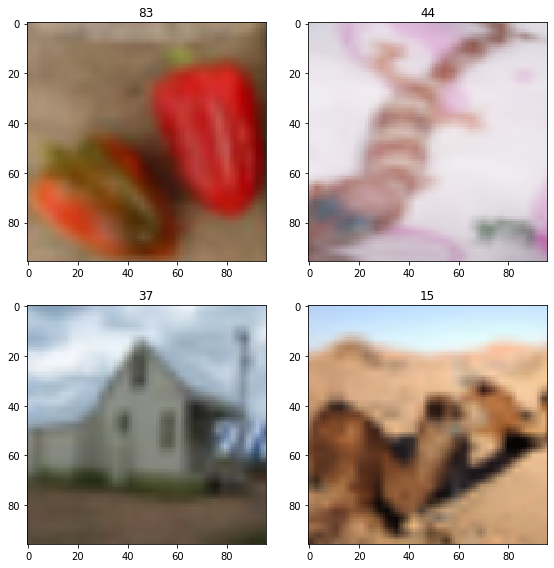

In [47]:
data.show_batch(rows=2, hide_axis=False)

In [48]:
learn = cnn_learner(data, models.resnet18, metrics=[error_rate, accuracy], pretrained=False).mixup()

In [51]:
learn.load('mixup200_64')

Learner(data=ImageDataBunch;

Train: LabelList (50000 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,0,0,0,0
Path: cifar100;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,0,0,0,0
Path: cifar100;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (co

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


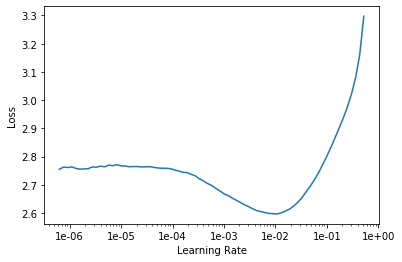

In [50]:
learn.lr_find()
learn.recorder.plot()

In [52]:
learn.fit_one_cycle(200, 6e-3, callbacks=SaveModelCallback(learn, name='resnet18_96'), wd=0.1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.377882,1.661123,0.412200,0.587800,05:03
1,2.129607,1.507352,0.382500,0.617500,05:21
2,1.984776,1.374036,0.352300,0.647700,05:19
3,1.895817,1.343974,0.349200,0.650800,05:19
4,1.825947,1.340454,0.345700,0.654300,05:16
5,1.771597,1.316296,0.339400,0.660600,05:20
6,1.718090,1.285329,0.330700,0.669300,05:43
7,1.676764,1.318950,0.339100,0.660900,05:10
8,1.631021,1.306450,0.335200,0.664800,05:08
9,1.598849,1.314645,0.329300,0.670700,05:05


Better model found at epoch 0 with valid_loss value: 1.6611227989196777.
Better model found at epoch 1 with valid_loss value: 1.5073521137237549.
Better model found at epoch 2 with valid_loss value: 1.3740355968475342.
Better model found at epoch 3 with valid_loss value: 1.3439741134643555.
Better model found at epoch 4 with valid_loss value: 1.3404537439346313.
Better model found at epoch 5 with valid_loss value: 1.3162963390350342.
Better model found at epoch 6 with valid_loss value: 1.285328984260559.
Better model found at epoch 146 with valid_loss value: 1.2839720249176025.
Better model found at epoch 153 with valid_loss value: 1.261664867401123.
Better model found at epoch 154 with valid_loss value: 1.2602170705795288.
Better model found at epoch 156 with valid_loss value: 1.2589538097381592.
Better model found at epoch 157 with valid_loss value: 1.249674916267395.
Better model found at epoch 158 with valid_loss value: 1.2473558187484741.
Better model found at epoch 160 with valid

KeyboardInterrupt: 

In [54]:
learn.fit_one_cycle(200, 6e-3, callbacks=SaveModelCallback(learn, name='resnet18_96'), start_epoch=190, wd=0.1)

Model resnet18_96_189 not found.


epoch,train_loss,valid_loss,error_rate,accuracy,time
190,1.101661,1.121069,0.271100,0.728900,09:26
191,1.100825,1.120704,0.270400,0.729600,09:20
192,1.101887,1.118360,0.269300,0.730700,09:35
193,1.101907,1.118413,0.269900,0.730100,09:31
194,1.094354,1.116621,0.269200,0.730800,09:45
195,1.095901,1.117548,0.270300,0.729700,10:18
196,1.100624,1.118221,0.270600,0.729400,10:05
197,1.101241,1.118563,0.270100,0.729900,10:22
198,1.095058,1.117949,0.269900,0.730100,09:53
199,1.090695,1.118525,0.269700,0.730300,09:48


Better model found at epoch 190 with valid_loss value: 1.1210688352584839.
Better model found at epoch 191 with valid_loss value: 1.1207038164138794.
Better model found at epoch 192 with valid_loss value: 1.118359923362732.
Better model found at epoch 194 with valid_loss value: 1.116620659828186.


In [55]:
learn.fit_one_cycle(200, 6e-3, callbacks=SaveModelCallback(learn, name='resnet18_96'), start_epoch=180, wd=0.1)

Model resnet18_96_179 not found.


epoch,train_loss,valid_loss,error_rate,accuracy,time
180,1.094906,1.130792,0.273000,0.727000,09:41
181,1.098977,1.127657,0.269500,0.730500,10:06
182,1.097976,1.138801,0.274200,0.725800,09:50
183,1.095390,1.123351,0.272300,0.727700,09:56
184,1.101347,1.128708,0.268700,0.731300,09:54
185,1.103541,1.120545,0.268600,0.731400,09:52
186,1.099746,1.120214,0.268000,0.732000,10:03
187,1.097616,1.120989,0.267300,0.732700,10:05
188,1.097357,1.115846,0.266700,0.733300,10:05
189,1.097059,1.115217,0.268000,0.732000,10:08


Better model found at epoch 180 with valid_loss value: 1.1307923793792725.
Better model found at epoch 181 with valid_loss value: 1.1276568174362183.
Better model found at epoch 183 with valid_loss value: 1.123350977897644.
Better model found at epoch 185 with valid_loss value: 1.1205447912216187.
Better model found at epoch 186 with valid_loss value: 1.1202138662338257.
Better model found at epoch 188 with valid_loss value: 1.115845799446106.
Better model found at epoch 189 with valid_loss value: 1.115216612815857.
Better model found at epoch 191 with valid_loss value: 1.1131374835968018.
Better model found at epoch 192 with valid_loss value: 1.1120959520339966.
Better model found at epoch 193 with valid_loss value: 1.1112138032913208.


In [57]:
learn.fit_one_cycle(220, 6e-3, callbacks=SaveModelCallback(learn, name='resnet18_96__'), start_epoch=180, wd=0.1)

Model resnet18_96___179 not found.


epoch,train_loss,valid_loss,error_rate,accuracy,time
180,1.109538,1.212131,0.291400,0.708600,10:31
181,1.123748,1.206399,0.291200,0.708800,10:27
182,1.123520,1.196451,0.286100,0.713900,10:33
183,1.123557,1.203960,0.287800,0.712200,10:37
184,1.120785,1.189389,0.283300,0.716700,10:43
185,1.120251,1.191710,0.284500,0.715500,10:46
186,1.121703,1.191914,0.283900,0.716100,11:08
187,1.112743,1.173061,0.282100,0.717900,10:50
188,1.110120,1.180446,0.283800,0.716200,10:45
189,1.114519,1.180402,0.286400,0.713600,10:50


Better model found at epoch 180 with valid_loss value: 1.2121307849884033.
Better model found at epoch 181 with valid_loss value: 1.2063989639282227.
Better model found at epoch 182 with valid_loss value: 1.1964513063430786.
Better model found at epoch 184 with valid_loss value: 1.189388632774353.
Better model found at epoch 187 with valid_loss value: 1.173061490058899.
Better model found at epoch 190 with valid_loss value: 1.1564682722091675.


KeyboardInterrupt: 